<a href="https://colab.research.google.com/github/sahandfrd94/Image-classificqation-by-Transfer-Learning-/blob/main/Image_classify_by_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import dataset from kaggle

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
!kaggle datasets download -d sanikamal/horses-or-humans-dataset

In [2]:
import zipfile

zip_ref = zipfile.ZipFile('/content/horses-or-humans-dataset.zip', 'r')
zip_ref.extractall('Dataset')

#Data Augmentaion

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_augmentor = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 45,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip=True
)
test_augmentor = ImageDataGenerator(
    rescale = 1/255
)

In [4]:
train_generator = train_augmentor.flow_from_directory(
    '/content/Dataset/horse-or-human/train',
    batch_size = 64,
    class_mode = 'binary',
    target_size = (160,160)
)

test_generator = test_augmentor.flow_from_directory(
    '/content/Dataset/horse-or-human/validation',
    batch_size = 64,
    class_mode = 'binary',
    target_size = (160,160)
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


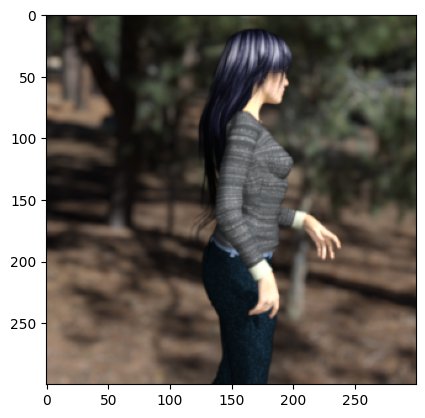

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('/content/Dataset/horse-or-human/train/humans/human02-28.png')[:,:,::-1]
plt.imshow(img)
plt.show()

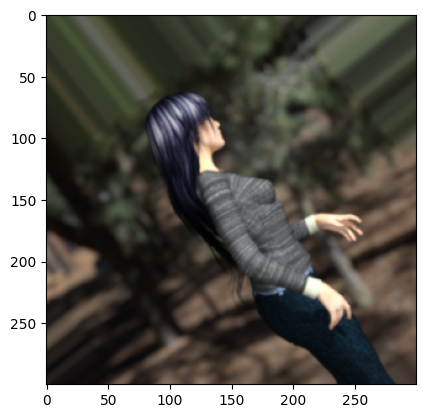

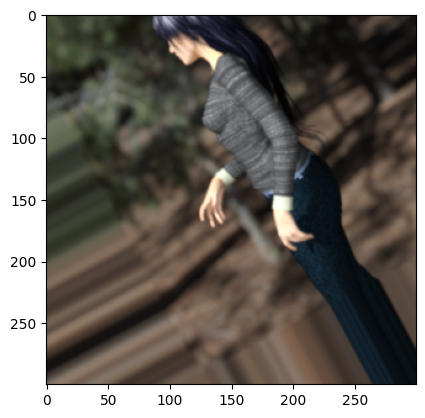

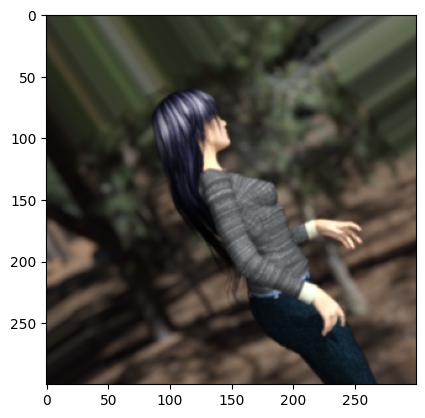

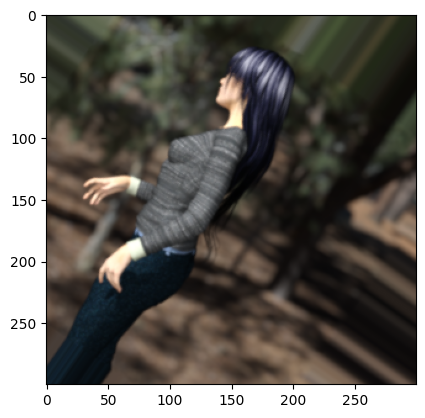

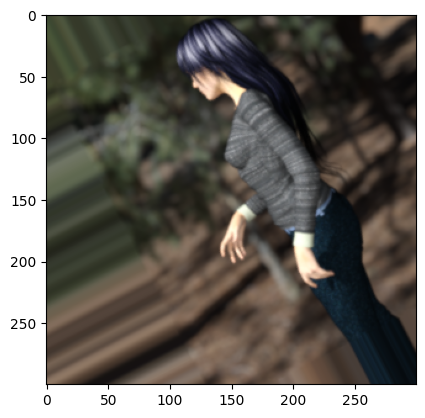

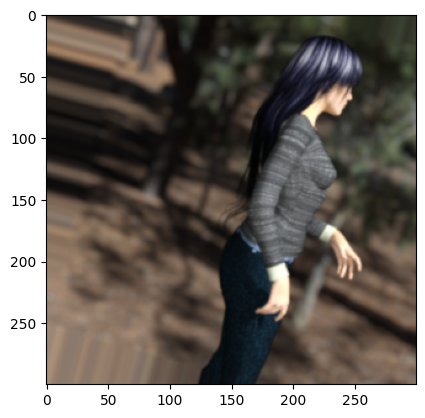

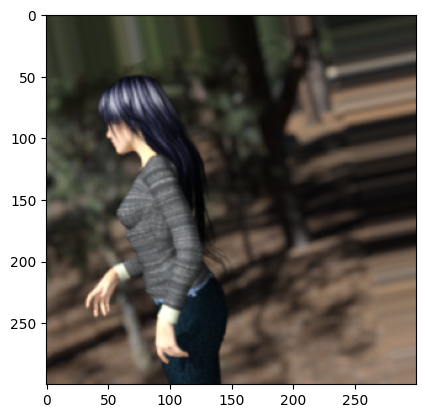

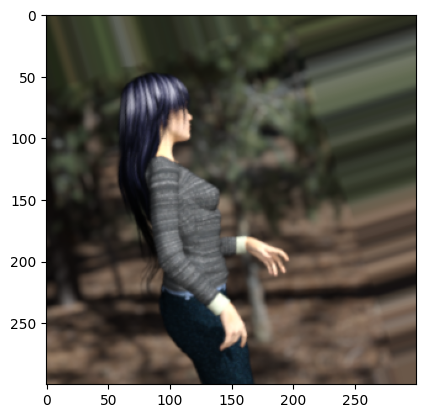

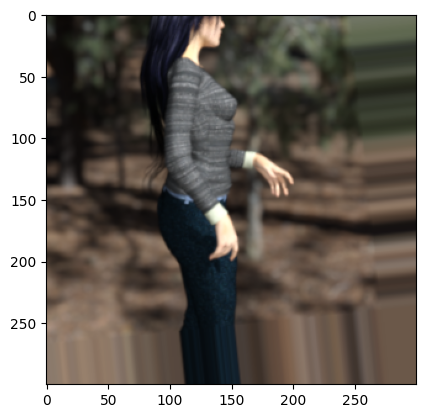

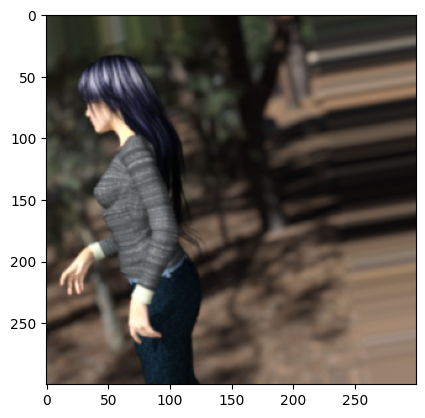

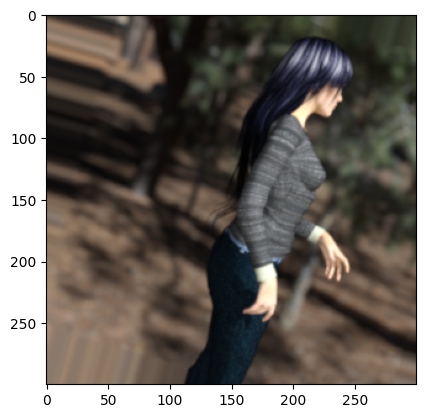

In [7]:
i = 0
img = np.expand_dims(img, axis = 0)

for batch in train_augmentor.flow(img , batch_size=1):
  plt.imshow(batch[0])
  plt.show()
  i = i+1
  if i > 10 :
    break

# Import MobileNetV2


In [13]:
from tensorflow.keras.applications import MobileNetV2
TL_model  = MobileNetV2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (160,160,3),
    pooling = max
)

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
TL_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

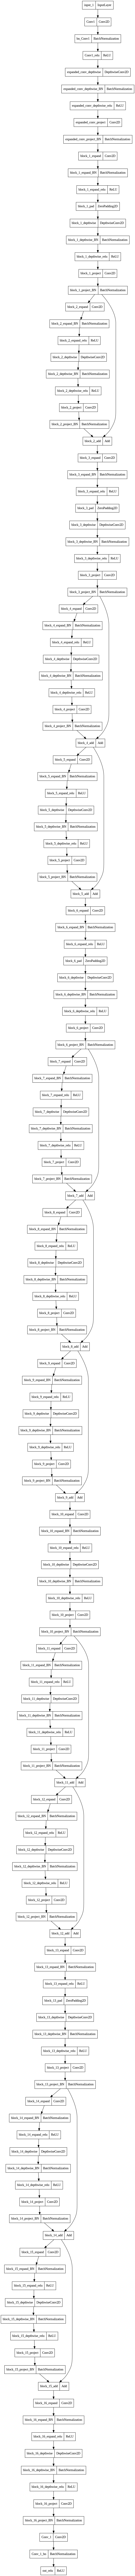

In [15]:
from keras.utils import plot_model
plot_model(TL_model)

In [16]:
for layer in TL_model.layers:
  layer.trainable = False

In [18]:
TL_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [20]:
last_layer= TL_model.get_layer('out_relu')
last_output = last_layer.output